In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import numpy as np
import torch
import math
import os

class_names = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I'
}

transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(), # Flip the data horizontally
            transforms.ToPILImage(),
            transforms.Resize((64, 64)),
            transforms.RandomAdjustSharpness(0.25),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomVerticalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])

# Load the data with all of the classes
root = 'data/birds1/'
data_dirs = os.listdir(root)
data_dirs = np.array(data_dirs)
data_dirs = data_dirs.flatten()

roots = np.array([root] * len(data_dirs))
data_dirs = np.core.defchararray.add(roots, data_dirs)

# data_list = np.array(data.imgs)

# Get the indices for the train/val/test split of 75/15/15
train_split = math.floor(0.9 * len(data_dirs))
val_split = math.ceil(0.05 * len(data_dirs))
test_split = val_split

# print(train_split + val_split + test_split, len(data_arr))

# Make sure the splits are correct
assert train_split + val_split + test_split == len(data_dirs)

# Split the dataset randomely
generator = torch.Generator().manual_seed(1)
train, val, test = torch.utils.data.random_split(data_dirs, [train_split, val_split, test_split], generator=generator)

len(train), len(val), len(test)

(3202, 178, 178)

In [3]:
import cv2

class GenData(torch.utils.data.Dataset):
    '''
        Data set class to store the feature maps
    
    '''

    def __init__(self, in_data, transform=None):
        # data = np.array(in_data)
        self.input_dirs = in_data
        # self.labels = data[:, 1]
        self.labels = []
        self.input_transform = transform[0]
        self.transform = transform[1]
        self.resize_transform = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize(128)
                                ])


    def __len__(self):
        return len(self.input_dirs)
    
    def __getitem__(self, idx):
        input_dir = self.input_dirs[idx]

        # Load the data
        inputs = cv2.imread(input_dir)
        inputs = cv2.cvtColor(inputs, cv2.COLOR_BGR2RGB)
        # inputs = inputs.swapaxes(0, 2)

        # labels = (int)(self.labels[idx])

        if self.transform:
            inputs = self.input_transform(inputs)
            transformed = self.transform(inputs)

            # labels = self.input_transform(labels)

            return inputs, transformed, inputs
        else:
            return inputs, inputs, inputs

In [4]:
# Create data loaders
def get_data_loaders(batch_size=1):
    
    train_data = GenData(data_dirs[train.indices], transform=(transform, transform))
    val_data = GenData(data_dirs[val.indices], transform=(transform, transform))
    test_data = GenData(data_dirs[test.indices], transform=(transform, transform))

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader


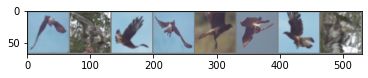

In [5]:
'''Code to visualize the data in the training set'''

import torchvision


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
train_dataloader, _, _ = get_data_loaders(8)
inputs, _, _ = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
# imshow(out, title=[class_names[x.item()] for x in classes])
imshow(out)

In [6]:
'''
Helper functions (based off of previous labs)
'''

def calculate_error(inputs, target):
    difference = torch.abs(target - inputs)
    mean_error = torch.mean(difference, dim=-1) # mean along width
    mean_error = torch.mean(mean_error, dim=-1) # mean along height
    mean_error = torch.mean(mean_error, dim=-1) # mean along channel

    # print(difference.size())
    # print(mean_error.size())
    # print(mean_error)

    return mean_error.sum()  


def evaluate(model, loader, criterion, cuda=False, batch_size=64, alex=False):
    '''
    Function to evaluate the model's performance on a val/test set
    '''


    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, transformed, labels = data

        ########## SENDING TO CUDA ############
        if cuda:
            inputs = inputs.to('cuda:0')
            transformed = transformed.to('cuda:0')
            
        

        outputs, latent_vector, mu, logvar = model(transformed)

        if alex:
            labels = labels.squeeze(1)

        # loss = 200 * criterion(outputs, inputs.float()) + 200 * vaekl_loss(outputs, inputs, mu, logvar, batch_size)
        loss =  model.loss_function(outputs, inputs, mu, logvar, M_N=10)['loss']


        # Find the mean error over the image
        output_err = calculate_error(outputs, inputs) 

        total_err += output_err
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss


def get_model_name(name, batch_size, learning_rate, momentum, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_m{3}_epoch{4}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   momentum,
                                                   epoch)
    return path


# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    # train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    # val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    # plt.title("Train vs Validation Error")
    n = len(train_loss) # number of epochs
    # plt.plot(range(1,n+1), train_err, label="Train")
    # plt.plot(range(1,n+1), val_err, label="Validation")
    # plt.xlabel("Epoch")
    # plt.ylabel("Error")
    # plt.legend(loc='best')
    # plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


In [7]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor

Tensor = TypeVar('torch.tensor')

from torch import nn
from abc import abstractmethod

class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

import torch
# from models import BaseVAE
from torch import nn
from torch.nn import functional as F
# from .types_ import *

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
    #nn.Linear(28*28, 300),
    #nn.LeakyReLU(0.2),
    #nn.Linear(300, 100),
    #nn.LeakyReLU(0.2),
    #nn.Linear(100, 1),
    #nn.Sigmoid())
    nn.Conv2d(3, 64, 4, 2, 1), # 64
    nn.LeakyReLU(0.2),
    nn.Conv2d(64, 128, 4, 2, 1), # 32 
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2),
    nn.Conv2d(128, 256, 4, 2 ,1), # 16
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2),
    nn.Conv2d(256, 512, 4, 2, 1), # 8
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2),
    nn.Conv2d(512, 1, 4, 1),
    nn.LeakyReLU(0.2),
    nn.Flatten(),
    # nn.Linear(1, 1)
    #nn.Sigmoid()
    )
  def forward(self, x):
    #x = x.view(x.size(0), -1)
    #out = self.model(x)
    #return out.view(x.size(0))
    x = self.model(x)
    x = x.squeeze(1)
    return x

class Generator(BaseVAE):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(Generator, self).__init__()

        self.latent_dim = latent_dim

        self.encoder_modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            self.encoder_modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                    nn.Dropout(0.3))
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*self.encoder_modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*16, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*16, latent_dim)


        # Build Decoder
        self.decoder_modules = []

        self.decoder_input = nn.Linear(latent_dim * 2, hidden_dims[-1] * 16)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            self.decoder_modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                    nn.Dropout(0.3))
            )



        self.decoder = nn.Sequential(*self.decoder_modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1))

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)


        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 256, 4, 4)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result
    
    def autoencoder(self, x) -> Tensor:
        # x = self.encoder(x) # x is (B, 512, 4, 4)
        # x = self.decoder(x)

        skip_connections = []

        for module in self.encoder_modules:
            x = module(x)
            skip_connections.append(x)

        # for connection in skip_connections:
        #     print(connection.size())

        skip_connections.reverse()
        count = 1

        for module in self.decoder_modules:
            x = module(x) + 0.01 * skip_connections[count]
            count+= 1


        x = self.final_layer(x)

        return x


    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, cuda=True, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        # noise = torch.randn(batch_size, 100)
        noise = torch.randn(z.size())
        if cuda:
            noise = noise.to('cuda:0')
        g = torch.cat([z, noise], axis=1)

        return  [self.decode(g), input, mu, log_var]
    
        '''
        
        Generator:

        input image -> (encoder, reparametrizes) -> latent vector

        latent vector + noise -> (decoder) -> output image

        Discriminator:
        output image -> discriminator
        
        '''

        # return [self.autoencoder(input), _, _, _]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        # print(recons.size(), input.size())

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss = F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = kld_weight * kld_loss
        # loss = recons_loss 

        # return {'loss': loss}

        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [8]:
def train_discriminator(discriminator, generator, inputs, latent_dim, criterion):
  # batch_size = img_to_tensor(images).size(0)
  batch_size = inputs.size(0)

  noise = torch.randn(batch_size, latent_dim)
  fake_images, _, _, _ = generator(inputs)
  inputs = torch.cat([inputs, fake_images])
  labels = torch.cat([torch.zeros(batch_size), # Real
  torch.ones(batch_size)]) # Fake

  labels = labels.to('cuda:0')
  outputs = discriminator(inputs)

  loss = criterion(outputs, labels)
  return outputs, loss

In [9]:
def train_generator(generator, discriminator, inputs, latent_dim, criterion):
  batch_size = inputs.size(0)
  noise = torch.randn(batch_size, 100)
  fake_images, _, mu, logvar = generator(inputs)
  outputs = discriminator(fake_images)
  # Only looks at fake outputs
  # gets rewarded if we fool the discriminator!
  labels = torch.zeros(batch_size)
  labels = labels.to('cuda:0')

  loss = criterion(outputs, labels) + generator.loss_function(fake_images, inputs, mu, logvar, M_N=100)['loss']
  return fake_images, loss


In [10]:
'''
Train Loop
'''

import tqdm
import time
from torch.optim import lr_scheduler

OUTPUT_DIR = 'runs/'

def train_network(generator, discriminator, batch_size=32, lr=0.005, momentum=0.9, num_epochs=30, cuda=True, loader=None, alex=False, sheduler=False):

    # Set manual seed for reproducible results
    torch.manual_seed(1)

    # Get the dataloaders with respective batch size
    train_dl, val_dl, _ = get_data_loaders(batch_size=batch_size)


    # Criterion and optimizer
    criterion = nn.BCEWithLogitsLoss()
    # optimizer =  optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    gen_optimizer =  optim.Adam(generator.parameters(), lr=lr, weight_decay=1e-3)
    disc_optimizer =  optim.Adam(discriminator.parameters(), lr=lr, weight_decay=1e-3)


    # Training metrics
    train_gen_loss = np.zeros(num_epochs)
    train_disc_loss = np.zeros(num_epochs)
    val_gen_loss = np.zeros(num_epochs)
    val_disc_loss = np.zeros(num_epochs)

    train_errors = np.zeros(num_epochs)
    val_errors = np.zeros(num_epochs)

    gen_losses = {'train': train_gen_loss, 'val': val_gen_loss}
    disc_losses = {'train': train_disc_loss, 'val': val_disc_loss}
    errors = {'train': train_errors, 'val': val_errors}

    best_train_err = 1000
    best_val_err = 1000

    ########## SENDING TO CUDA ############
    if cuda:
        generator = generator.to('cuda:0')
        discriminator = discriminator.to('cuda:0')

    start_time = time.time()
    generator.train()
    discriminator.train()

    # Train loop
    for epoch in tqdm.tqdm(range(num_epochs)):
        for mode in ('train', 'val'): 
            total_loss_gen = 0.0
            total_loss_disc = 0.0
            total_error = 0.0
            total_epoch = 0

            for i, data in enumerate(train_dl if mode == 'train' else val_dl):

                inputs, transformed, labels = data
                # print(inputs.size())


                ########## SENDING TO CUDA ############
                if cuda:
                    inputs = inputs.to('cuda:0')
                    transformed = transformed.to('cuda:0')

                _, disc_loss = train_discriminator(discriminator, generator, inputs, generator.latent_dim, criterion = criterion)
                if mode == 'train':
                    disc_loss.backward()
                    disc_optimizer.step()
                    disc_optimizer.zero_grad()

                outputs, gen_loss = train_generator(generator, discriminator, inputs, generator.latent_dim, criterion = criterion)
                if mode == 'train':
                    gen_loss.backward()
                    gen_optimizer.step()
                    gen_optimizer.zero_grad()
                
                output_err = calculate_error(outputs, inputs)

                total_error += output_err


                total_loss_gen += gen_loss.item()
                total_loss_disc += disc_loss.item()
                total_epoch += len(labels)

            # if sheduler:
            #     exp_lr_scheduler.step()

            gen_losses[mode][epoch] = float(total_loss_gen) / (i + 1)
            disc_losses[mode][epoch] = float(total_loss_disc) / (i + 1)
            errors[mode][epoch] = float(total_error) / (total_epoch)
        

        tqdm.tqdm.write(f'Epoch {epoch}: Gen Train Loss: {gen_losses["train"][epoch]}, Disc Train Loss: {disc_losses["train"][epoch]} |\n Gen Val Loss: {gen_losses["val"][epoch]}, Disc Val Loss: {disc_losses["val"][epoch]}')
        # tqdm.tqdm.write(f'Train Error: {errors[mode][epoch]} | Validation Error: {errors[mode][epoch]}')

        # Check whether a better train/val err has been found
        # better = False
        # if train_err[epoch] < best_train_err:
        #     best_train_err = train_err[epoch]
        #     better = True
        # if val_err[epoch] < best_val_err:
        #     best_val_err = val_err[epoch]
        #     better = True

        # if better or epoch == (num_epochs - 1):
        #     model_path = OUTPUT_DIR + get_model_name(model.name, batch_size, lr, momentum, epoch)

        #     torch.save(model.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    gen_model_path = OUTPUT_DIR + get_model_name(generator.name, batch_size, lr, momentum, epoch)
    np.savetxt("{}_train_loss.csv".format(gen_model_path), gen_losses['train'])
    np.savetxt("{}_val_loss.csv".format(gen_model_path), gen_losses['val'])
    
    disc_model_path = OUTPUT_DIR + get_model_name(discriminator.name, batch_size, lr, momentum, epoch)
    np.savetxt("{}_train_loss.csv".format(disc_model_path), disc_losses['train'])
    np.savetxt("{}_val_loss.csv".format(disc_model_path), disc_losses['val'])



In [11]:
from torchsummary import summary

model = Generator(3, 256, [32, 64, 128, 256])
model.to('cuda:0')

summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
         LeakyReLU-7           [-1, 64, 16, 16]               0
           Dropout-8           [-1, 64, 16, 16]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
        LeakyReLU-11            [-1, 128, 8, 8]               0
          Dropout-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 256, 4, 4]         295,168
      BatchNorm2d-14            [-1, 25

In [12]:
from torchsummary import summary

model = Discriminator()
model.to('cuda:0')

summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,200
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,544
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,664
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,193
        LeakyReLU-13              [-1, 1, 1, 1]               0
          Flatten-14                   

In [13]:
gen_model = Generator(3, 256, [32, 64, 128, 256])
disc_model = Discriminator()

gen_model.name = 'gen'
disc_model.name = 'disc'

In [20]:
batch = 64
lr = 0.007
m = 0.9
epochs = 500

train_network(gen_model, disc_model, batch_size=batch, lr=lr, momentum=m, num_epochs=epochs, cuda=True)
model_path =  OUTPUT_DIR + get_model_name(gen_model.name, batch, lr, m, epochs-1)
plot_training_curve(model_path)

  0%|          | 1/500 [00:21<2:55:21, 21.09s/it]

Epoch 0: Gen Train Loss: 170.90989574264077, Disc Train Loss: 0.047044132880032785 |
 Gen Val Loss: 19.390888532002766, Disc Val Loss: 0.0001116502001726379


  0%|          | 2/500 [00:41<2:51:28, 20.66s/it]

Epoch 1: Gen Train Loss: 13536.978264191572, Disc Train Loss: 0.00016925118524893916 |
 Gen Val Loss: 55.08385213216146, Disc Val Loss: 9.161571991474678e-05


  1%|          | 3/500 [01:01<2:48:38, 20.36s/it]

Epoch 2: Gen Train Loss: 1218.5840397255095, Disc Train Loss: 0.00016810167232738334 |
 Gen Val Loss: 339.6891377766927, Disc Val Loss: 0.0006550007383339107


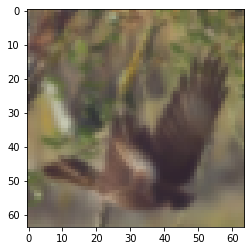

torch.Size([1, 3, 64, 64])


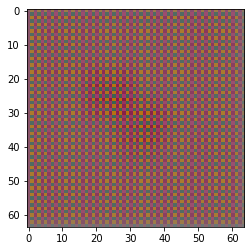

In [19]:
train_dl, val_dl, _ = get_data_loaders(batch_size=1)

gen_model.eval()
gen_model = gen_model.to('cuda')
count = 0
for data in train_dl:
    count += 1
    if count < 100:
        continue
    img, _, _ = data
    img = img.to('cuda')
    imshow(img[0])
    
    out = gen_model(img)
    out = out[0].detach()
    print(out.shape)
    imshow(out[0])
    print()
    
    break